# Process Stability and Capability Analysis

### 0. Libraris and SetUp

In [4]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from scipy import stats
from scipy.stats import norm, poisson, ttest_1samp

sns.set_theme("notebook", style="whitegrid")
warnings.filterwarnings("ignore")

### 1. Custom Functions - Charts and SixSigma Calucator

In [5]:
def calculate_center_line(data, column_name):
    """Calculates the center line for the control chart."""
    return data[column_name].mean()


def calculate_control_limits(center, average_defects_per_unit, multiplier):
    """Calculates upper and lower control limits."""
    std_dev = np.sqrt(average_defects_per_unit)
    upper_limit = center + multiplier * std_dev
    lower_limit = center - multiplier * std_dev
    return upper_limit, lower_limit


def create_c_chart(data):
    """Creates a C chart for the given data."""
    center_line = calculate_center_line(data, "no_of_resources")
    control_limits = calculate_control_limits(
        center_line, center_line, 3
    )  # 3 sigma limits
    plt.figure(figsize=(10, 6))
    plt.plot(data["row_nr"], data["no_of_resources"], "o-", label="no_of_resources")
    plt.axhline(y=center_line, color="r", linestyle="--", label="Center Line")
    plt.axhline(y=control_limits[0], color="b", linestyle="--", label="UCL")
    plt.axhline(y=control_limits[1], color="b", linestyle="--", label="LCL")
    plt.xlabel("Project")
    plt.ylabel("Number of Resources")
    plt.title("C Chart")
    plt.legend()
    plt.grid(True)
    plt.show()


def create_run_chart(data, column_name):
    """Creates a run chart for the given data."""
    plt.figure(figsize=(25, 6))
    plt.plot(data.index, data[column_name], marker="o", linestyle="-")
    plt.xlabel(
        "Projects-From Jan to Dec-2023"
    )  # Assuming the index represents time periods
    plt.ylabel(column_name)  # Replace with the actual column name
    plt.title("Run Chart for " + column_name)
    plt.grid(True)
    plt.show()


def get_six_sigma_caluclator():
    """ISI Custom SixSigma Calucator"""
    while True:
        ### Inputs
        print(f"-------------------------------------------------")
        print(f"############ Sigma Caluclator Inputs ############")
        print(f"-------------------------------------------------")
        _mean = float(input("Enter the mean:"))
        _sd = float(input("Enter Standard Deviation:"))
        _LSL = float(input("Enter LSL:"))
        _USL = float(input("Enter USL:"))
        # Formulas and caluclations
        ZLSL = (_LSL - _mean) / _sd
        ZUSL = (_USL - _mean) / _sd
        Area_ZLSL = norm.cdf(ZLSL)
        Area_ZUSL = 1 - norm.cdf(ZUSL)
        TOTAL_NC = Area_ZLSL + Area_ZUSL
        YIELD = 1 - TOTAL_NC
        CP_ = (_USL - _LSL) / (6 * _sd)
        _A = (_USL - _mean) / (3 * _sd)
        _B = (_mean - _LSL) / (3 * _sd)
        CPK_ = min(_A, _B)
        SIGMA_LEVEL = round(1.5 + norm.ppf(YIELD), 5)
        DPMO = TOTAL_NC * 1000000
        # Output
        print(f"-------------------------------------------------")
        print(f"#### Summary Report ####")
        print(f"-------------------------------------------------")
        print(f"Total NonConfirmances:{round(TOTAL_NC,5)}")
        print(f"Yield:{round(YIELD,5)}")
        print(f"CP:{round(CP_,5)}")
        print(f"CPK:{round(CPK_,5)}")
        print(f"SIGMA_LEVEL:{round(SIGMA_LEVEL,5)}")
        print(f"DPMO:{round(DPMO,5)}")
        print(f"-------------------------------------------------")
        _next = input(
            "Would you like to continue to use sigma caluclator type 'yes' if so :"
        )
        if _next.lower() == "yes":
            continue
        else:
            print(f"Thanks for using Sigma Caluclator..")
            print(f"#### END ####")
            break

### 2. Data Imports and Preparations

In [6]:
df_track = pl.read_excel(
    r"/Users/malleshamyamulla/Desktop/SSBBA/data_training_1/data/DBAS_SDS_Projects_2023_V2.xlsx"
)

df_track_tidy = (
    df_track.with_columns(
        pl.col("Team Member Name").str.split(",").list.len().alias("no_of_resources")
    )
    .sort("Started Date")
    .with_row_count()
)

df_track_tidy_numericals = df_track_tidy.select(
    [
        "row_nr",
        "NO_OF_DAYS_NORM",
        "NO_OF_SERVICE_WORKING_HRS",
        "Total Files",
        "no_of_resources",
    ]
)

Our Data Breach Discovery Analytics process leverages data mining techniques to automatically extract PII/PHI information from various file systems. While automation streamlines the process, a team of analysts still reviews a subset of 10-20% of files manually for added assurance.

To ensure transparency and tracking, we do record details for each project undergoing manual review. This record includes project name, number of files reviewed, start and end dates in a clear format, and the number of analysts involved.

**Note**: As part of the assignment i have considered this real data to perform the stated analysis. Course Project that i'm planning to carry out would deal with another targer variable i.e DOCUMENT CLASSIFICATION/DEDUPLICATION,This future analysis could potentially incorporate the findings from the current assignment as well.

In [7]:
df_track_tidy.head()

row_nr,Project Name,Total Files,Started Date,Complete Date,Team Member Name,NO_OF_DAYS,NO_OF_DAYS_NORM,NO_OF_SERVICE_WORKING_HRS,no_of_resources
u32,str,i64,str,str,str,i64,i64,i64,u32
0,"""PROJECT_1""",15,"""01-03-23""","""01-04-23""","""Karthik""",1,2,16,1
1,"""PROJECT_2""",2437,"""01-09-23""","""01-12-23""","""Anitha,Saikris…",3,4,32,11
2,"""PROJECT_4""",9,"""01-09-23""","""01-09-23""","""Naresh K,Sneh,…",0,1,8,4
3,"""PROJECT_5""",14,"""01-10-23""","""01-10-23""","""Anitha""",0,1,8,1
4,"""PROJECT_6""",26,"""01-12-23""","""01-13-23""","""Anusha,Saikris…",1,2,16,6


### 3. Process Stability and Capability Analysis

The manual document review process makes it difficult to determine the optimal number of analysts needed for each project, leading to delays in project delivery. If we can streamline the process of assigning analysts to projects, we can optimize resource allocation and ensure timely data notification delivery.

We have collected the last one year's 260 projects data as showed about and out target variable is no_of_resources are used for each of the project

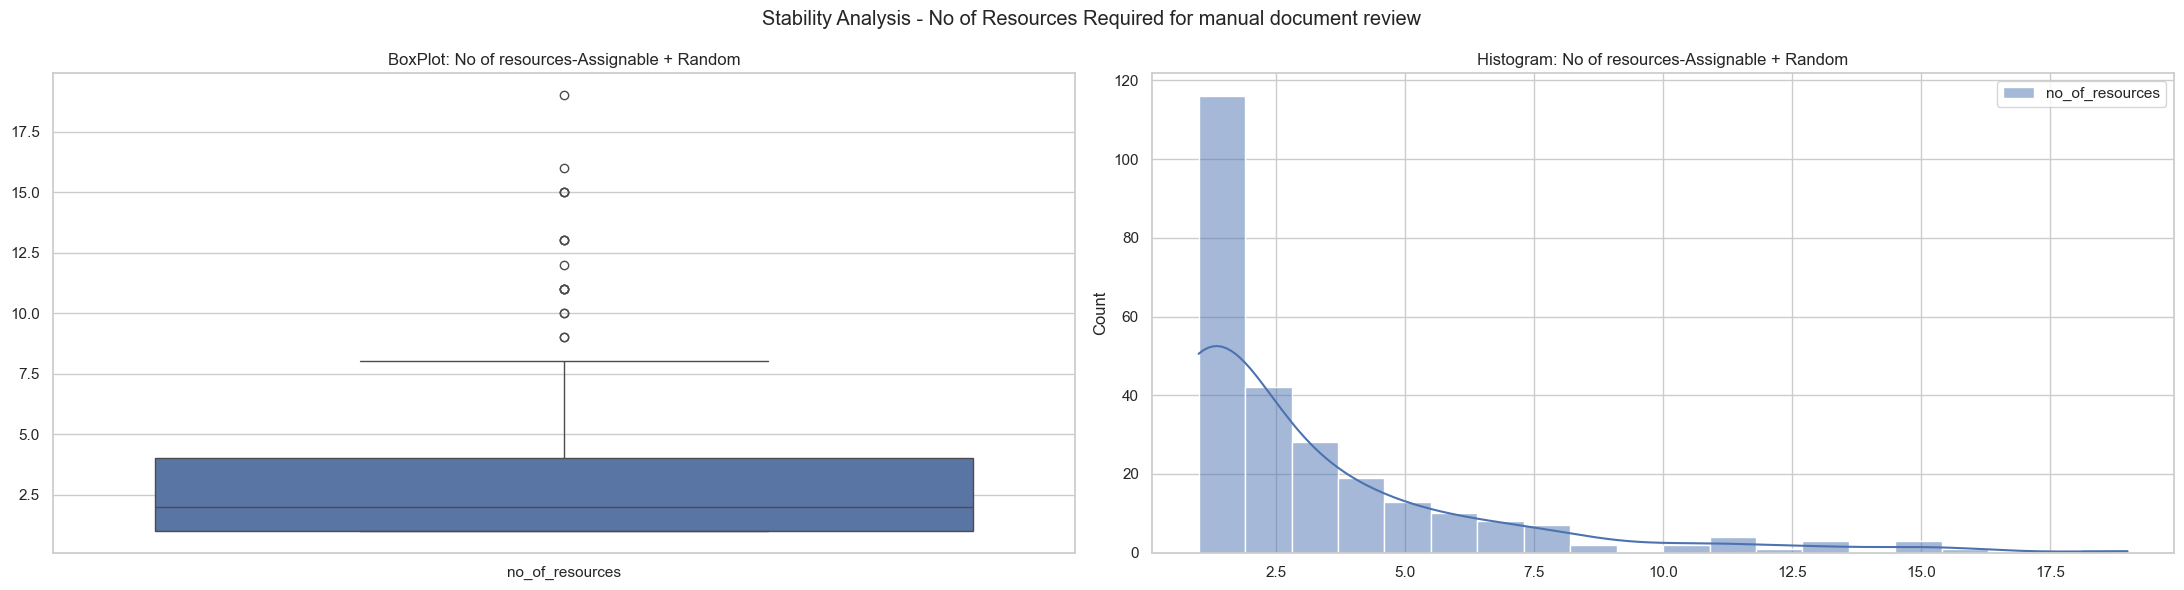

In [8]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1 = sns.boxplot(df_track_tidy_numericals.select("no_of_resources").to_pandas(), ax=ax1)
p2 = sns.histplot(
    df_track_tidy_numericals.select("no_of_resources").to_pandas(), ax=ax2, kde=True
)
p1.set_title("BoxPlot: No of resources-Assignable + Random")
p2.set_title("Histogram: No of resources-Assignable + Random")
plt.suptitle("Stability Analysis - No of Resources Required for manual document review")
plt.tight_layout()
plt.show()

**Note**:
1. The number of resources required per project exhibits a Poisson distribution, with an average of 3 analysts assigned per project.

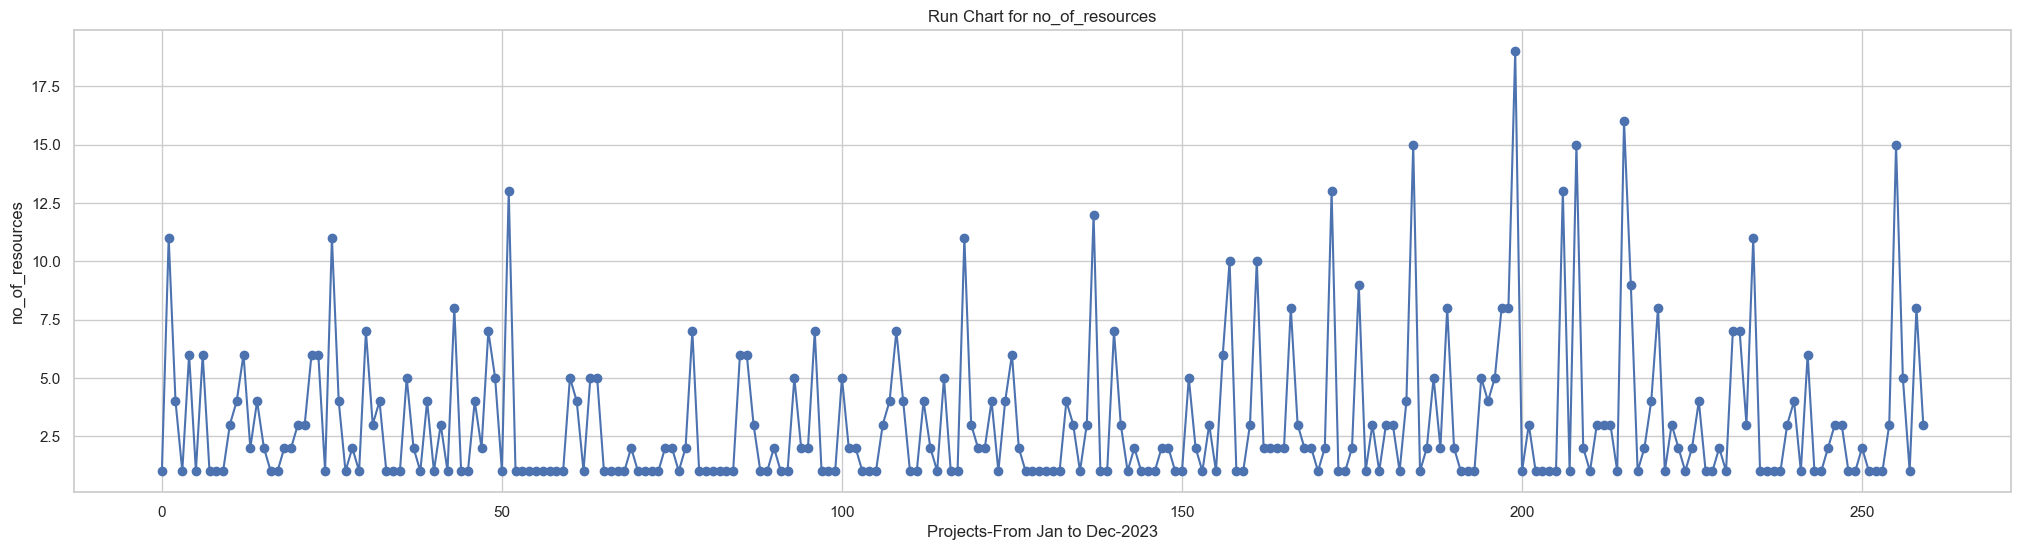

In [9]:
create_run_chart(
    df_track_tidy_numericals.select("no_of_resources").to_pandas(), "no_of_resources"
)

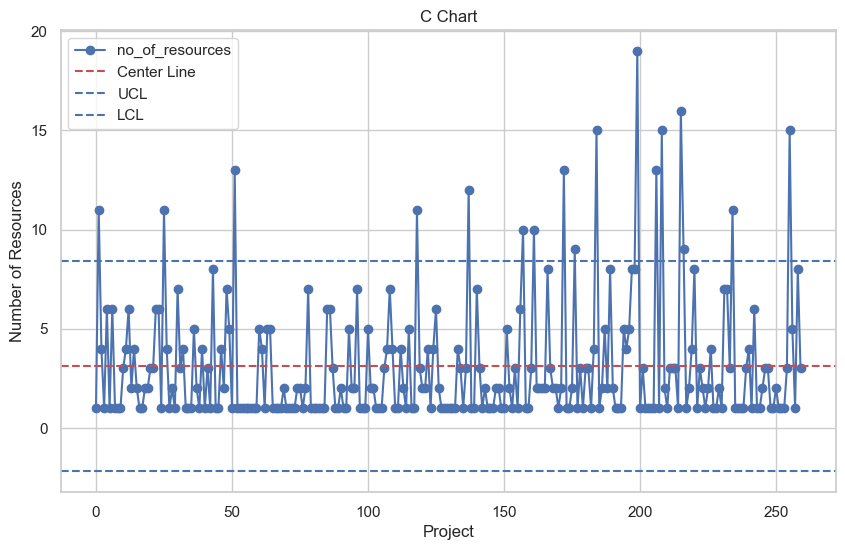

In [10]:
create_c_chart(
    df_track_tidy_numericals.select("no_of_resources").with_row_count().to_pandas()
)

**Note:**

1. We identified a significant number (approximately 218) of assignable causes in the process. These warrant further investigation to understand their root causes and implement corrective actions. 

#### 3.1 Investigation on Assignable causes

In [11]:
df_track_random = (
    df_track_tidy.select(pl.col(["row_nr", "no_of_resources"]))
    .filter((pl.col("no_of_resources") < 7) & (pl.col("no_of_resources") > 3))
    .with_columns(pl.lit("RANDOM").alias("Type"))
)

In [12]:
df_track_tidy_v2 = df_track_tidy.join(
    df_track_random.select(["row_nr", "Type"]), on="row_nr", how="left"
).with_columns(
    pl.when(pl.col("Type").is_null())
    .then(pl.lit("Assignable").alias("Type"))
    .otherwise(pl.col("Type"))
)

In [13]:
df_assignable_counts = (
    df_track_tidy_v2.select(["Type", "no_of_resources"])
    .filter(pl.col("Type") == "Assignable")
    .select("no_of_resources")
    .sort("no_of_resources")
    .with_columns(pl.col("no_of_resources").cast(pl.Utf8))
    .group_by("no_of_resources")
    .count()
    .to_pandas()
    .sort_values("no_of_resources")
)

In [14]:
pl.from_pandas(df_assignable_counts).with_columns(
    pl.sum("count").alias("sum_of_asg")
).with_columns((pl.col("count") / pl.col("sum_of_asg")).alias("perc"))

no_of_resources,count,sum_of_asg,perc
str,u32,u32,f64
"""1""",116,218,0.53211
"""10""",2,218,0.009174
"""11""",4,218,0.018349
"""12""",1,218,0.004587
"""13""",3,218,0.013761
…,…,…,…
"""2""",42,218,0.192661
"""3""",28,218,0.12844
"""7""",8,218,0.036697


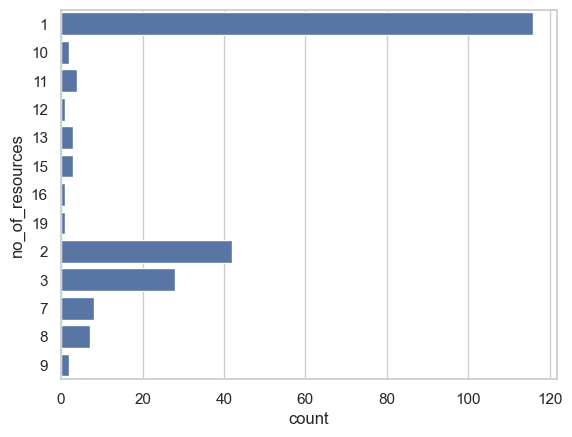

In [15]:
sns.barplot(df_assignable_counts, y="no_of_resources", x="count")
plt.show()

**Notes:**
1. No of Data Points considered as Assignable causes ~ 218
    
2. Out of 218 total assignable causes, approximately 116 are assignable to projects requiring only one person,This suggests that 85% of assignable causes come from projects with a small resource requirement of 1, 2, or 3 people. 

3. High-priority projects typically necessitate a larger team of analysts for successful delivery. This is reflected by the increased number of resources required, often ranging from 11 to 19 analysts.

4. We have done an investigation on these 218 data points and tag them as ASSINGNABLE and the remaining are as RANDOM once.
5. We would now conduct a stability analysis on thes RANDOM chance data points

In [16]:
df_random_resources = df_track_tidy_v2.filter(pl.col("Type") == "RANDOM").select(
    "no_of_resources"
)

#### 3.2 Hypothesis One Mean

##### Ho: Average number of resource persons for manual review 5
##### HA: Average number of resource persons for manual review not equal to 5

In [17]:
infer_v1 = ttest_1samp(
    df_random_resources.select("no_of_resources").to_numpy(), popmean=5
)
_PVAL = infer_v1.pvalue[0]
_L, _R = (
    infer_v1.confidence_interval(0.95)[0][0],
    infer_v1.confidence_interval(0.95)[1][0],
)
print(
    f"P-Value Caluclated is:{round(_PVAL,3)} which is greater than to 0.05, hence we failed to reject the null hypothesis."
)
print(
    f"We are 95% confident the true mean no of resources require for manual document review: is between {round(_L,3)} and {round(_R,3)}"
)

P-Value Caluclated is:0.095 which is greater than to 0.05, hence we failed to reject the null hypothesis.
We are 95% confident the true mean no of resources require for manual document review: is between 4.532 and 5.039


#### 3.3 Control Charts- Run Chart and C Chart

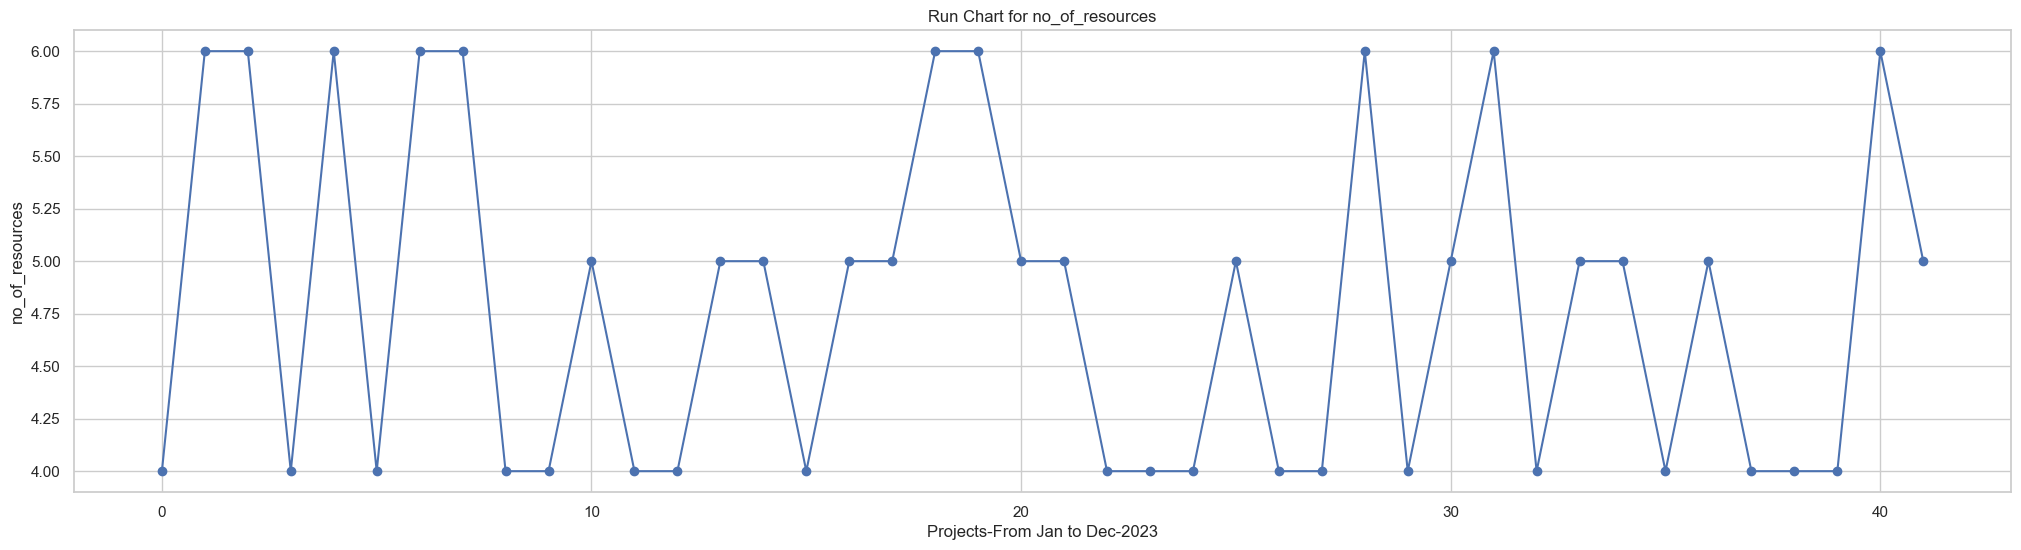

In [18]:
create_run_chart(df_random_resources.to_pandas(), "no_of_resources")

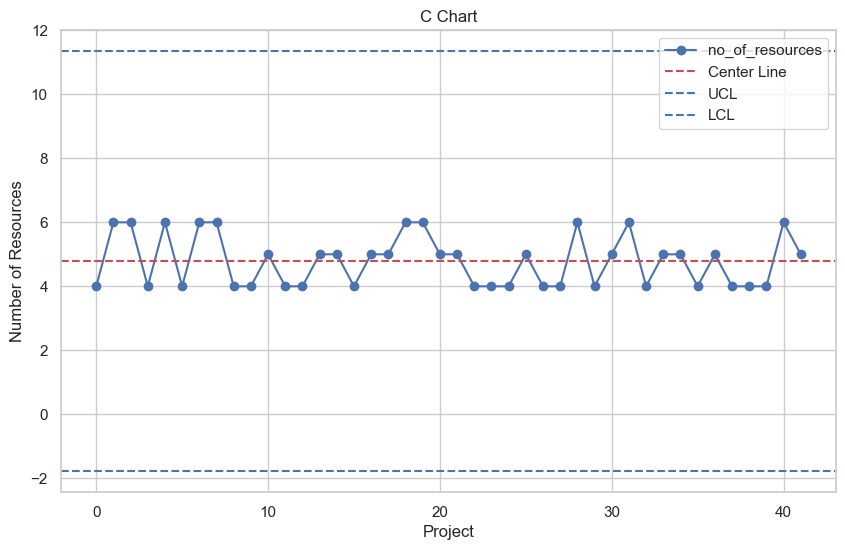

In [19]:
create_c_chart(df_random_resources.with_row_count().to_pandas())

#### 3.4 Box Plot and Histogram - Random Variability

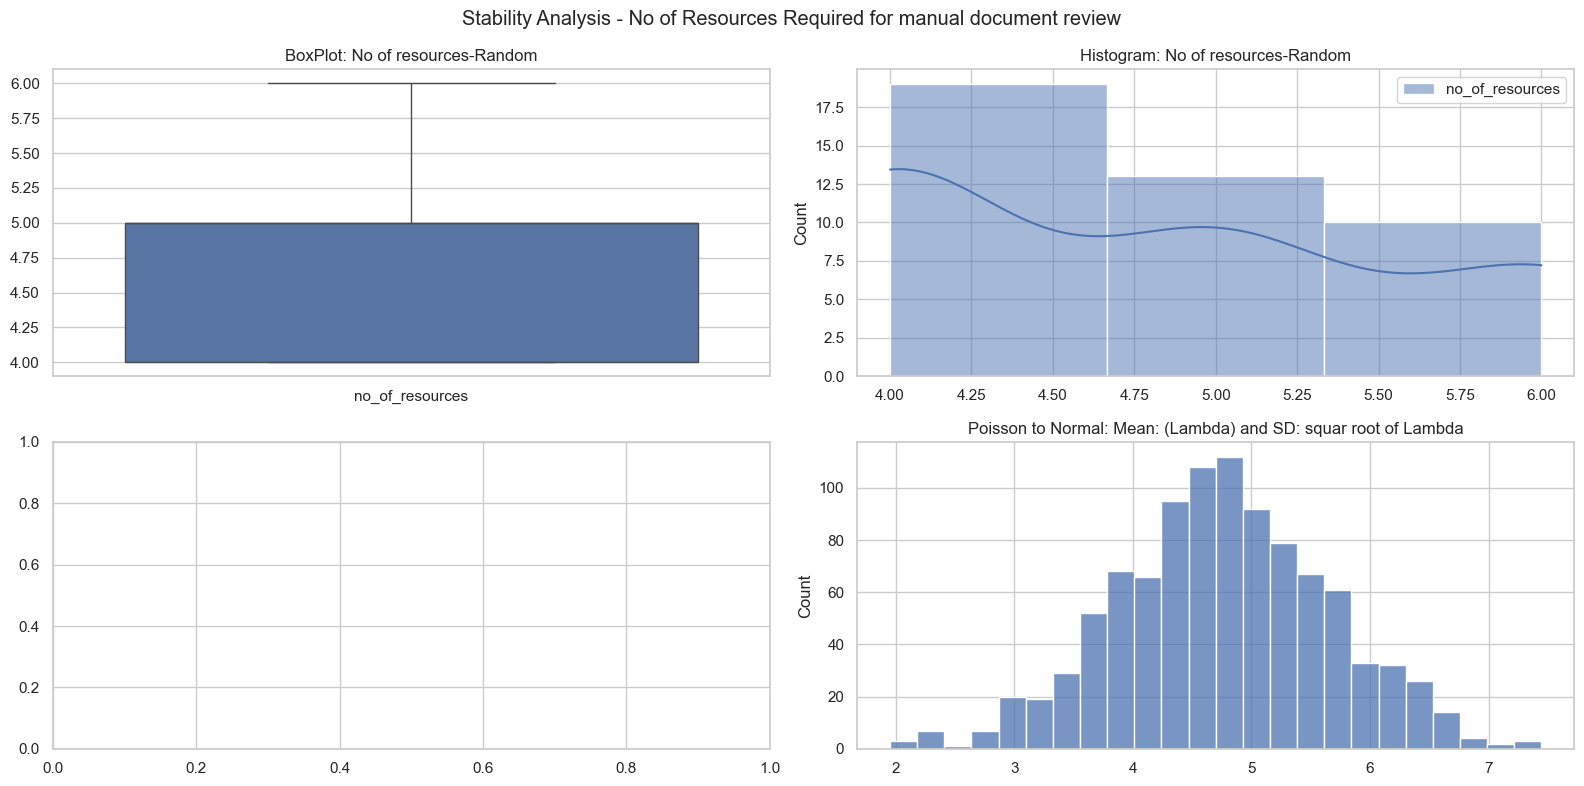

In [20]:
# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
p1 = sns.boxplot(
    df_random_resources.select("no_of_resources").to_pandas(), ax=axes[0, 0]
)
p2 = sns.histplot(
    df_random_resources.select("no_of_resources").to_pandas(),
    ax=axes[0, 1],
    kde=True,
    bins=3,
)
p5 = sns.histplot(norm.rvs(4.78, round(np.sqrt(0.8), 3), 1000), ax=axes[1, 1])
p1.set_title("BoxPlot: No of resources-Random")
p2.set_title("Histogram: No of resources-Random")
p5.set_title("Poisson to Normal: Mean: (Lambda) and SD: squar root of Lambda")
plt.suptitle("Stability Analysis - No of Resources Required for manual document review")
plt.tight_layout()
plt.show()

**Notes:**
1. After identifying and removing assignable causes, we re-analyzed the process to assess the stability of remaining random variations in the number of resources required for statistically stable manual review. This analysis will help us determine the optimal resource allocation for future projects.

### 4. SIGMA CALUCLATOR

    1. Mean: Number of Resource Persons Utilized for Manual Review ~ 5
    2. SD:   Standard Deviation ~ 0.8
    3. Business Specifications:
         - LSL: ~ 2
         - USL: ~ 8

In [21]:
get_six_sigma_caluclator()

-------------------------------------------------
############ Sigma Caluclator Inputs ############
-------------------------------------------------


Enter the mean: 5
Enter Standard Deviation: 0.8
Enter LSL: 2
Enter USL: 8


-------------------------------------------------
#### Summary Report ####
-------------------------------------------------
Total NonConfirmances:0.00018
Yield:0.99982
CP:1.25
CPK:1.25
SIGMA_LEVEL:5.07244
DPMO:176.83457
-------------------------------------------------


Would you like to continue to use sigma caluclator type 'yes' if so : no


Thanks for using Sigma Caluclator..
#### END ####


**Note**
1. The process capability index (Cp) of 1.25 indicates low variability. While this means all current business requirements are likely being met.
2. The process achieved index(Cpk) of 1.25 is also same as Cp,it suggests the process mean is likely centered between the upper and lower specification limits.

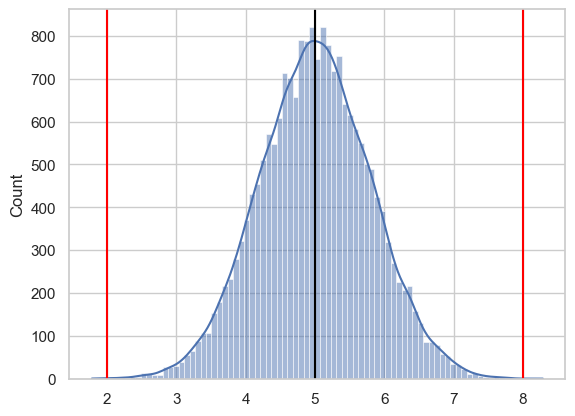

In [22]:
sns.histplot(norm.rvs(5, 0.8, 20000),kde=True)
plt.axvline(5,color='black')
plt.axvline(2,color='red')
plt.axvline(8,color='red')
plt.show()